# 움직임 감지

## 영상 내 이미지

In [2]:
import cv2
import numpy as np
col_image = []

video = cv2.VideoCapture("project_video.mp4")
if video.isOpened():
    
    while True:
        ret, img = video.read()
        if ret:
            col_image.append(img)
        else:
            break
        
video.release()

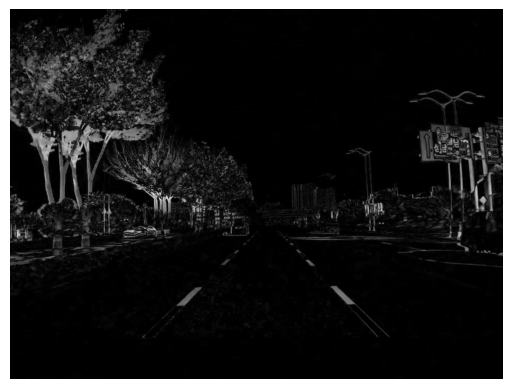

In [5]:
from matplotlib import pyplot as plt

grayA = cv2.cvtColor(col_image[22], cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(col_image[23], cv2.COLOR_BGR2GRAY)
diff = cv2.absdiff(grayB, grayA)

plt.imshow(diff, cmap='gray')
plt.axis('off')
plt.show()

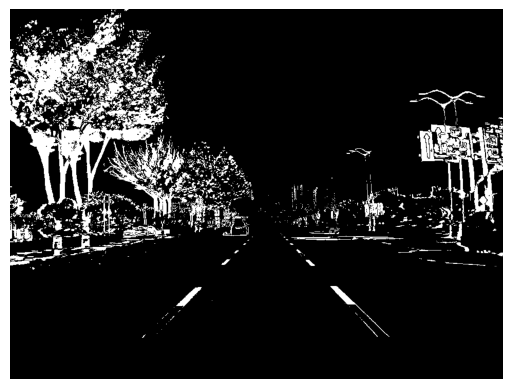

In [6]:
ret, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.show()

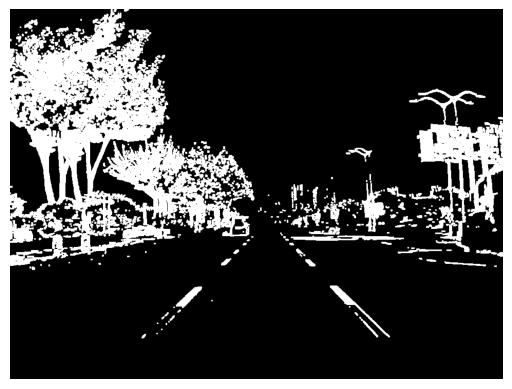

In [7]:
kernel = np.ones((3,3),np.uint8)
dilated = cv2.dilate(thresh, kernel, iterations = 1)
plt.imshow(dilated, cmap='gray')
plt.axis('off')
plt.show()

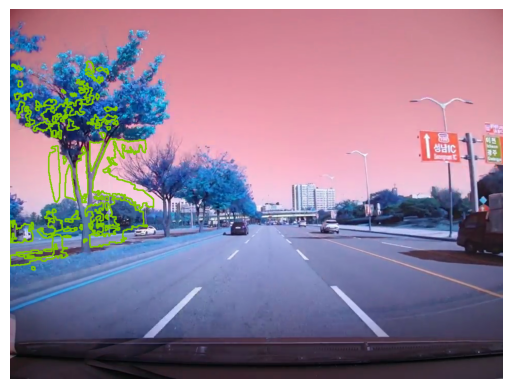

In [8]:
contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
valid_cntrs = []
for i,cntr in enumerate(contours):
    x,y,w,h = cv2.boundingRect(cntr)
    if (x <= 200) & (y >= 100) & (cv2.contourArea(cntr) >= 25):
        valid_cntrs.append(cntr)

len(valid_cntrs)
dmy = col_image[22].copy()

cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
plt.imshow(dmy)
plt.axis('off')
plt.show()

## 영상 전체

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import re

col_images = []

video = cv2.VideoCapture("project_video.mp4")
if video.isOpened():
    while True:
        ret, img = video.read()
        if ret:
            col_images.append(img)
        else:
            break
video.release()

font = cv2.FONT_HERSHEY_SIMPLEX
kernel = np.ones((4,4),np.uint8)

for i in range(len(col_images)-1):
    grayA = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(col_images[i+1], cv2.COLOR_BGR2GRAY)
    diff_image = cv2.absdiff(grayB, grayA)
    
    ret, thresh = cv2.threshold(diff_image, 30, 255, cv2.THRESH_BINARY)
    dilated = cv2.dilate(thresh, kernel, iterations = 1)
    contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    valid_cntrs = []
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        if  (x <= 640) & (y >= 160) & (y < 260) & (cv2.contourArea(cntr) >= 40):
            valid_cntrs.append(cntr)
            
    dmy = col_images[i].copy()
    cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
    
    cv2.putText(dmy, "vehicles detected: " + str(len(valid_cntrs)), (55,15), font, 0.6, (0,180,0), 2)
    cv2.line(dmy, (0, 160),(640,160),(100, 255, 255))
    cv2.line(dmy, (0, 260),(640,260),(100, 255, 255))
    cv2.imshow("image", dmy)
    cv2.waitKey(10)
    cv2.destroyAllWindows()

# 차선 검출

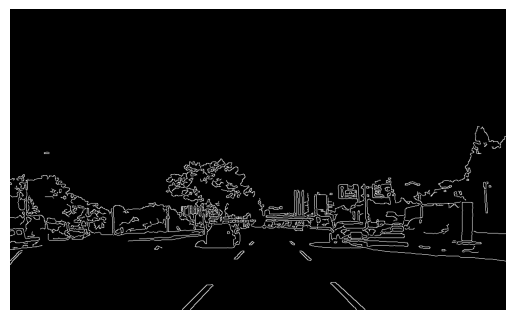

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def edge_detector(frame):
    """
    주어진 프레임에서 에지를 감지하는 함수입니다.

    이 함수는 다음 단계를 수행합니다:
    1. 프레임을 그레이스케일로 변환합니다.
    2. 그레이스케일 이미지를 가우시안 블러를 사용하여 블러링합니다.
    3. 블러링된 이미지에서 Canny 알고리즘을 사용하여 에지를 감지합니다.

    Args:
        frame (numpy.ndarray): 에지를 감지할 입력 프레임. 일반적으로 BGR 형식의 이미지입니다.

    Returns:
        numpy.ndarray: 감지된 에지가 포함된 이진 이미지.
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edge = cv2.Canny(blur, 50, 150)
    return edge


image = cv2.imread("car.png")
canny_img = edge_detector(image)
plt.imshow(canny_img, cmap='gray')
plt.axis('off')
plt.show()

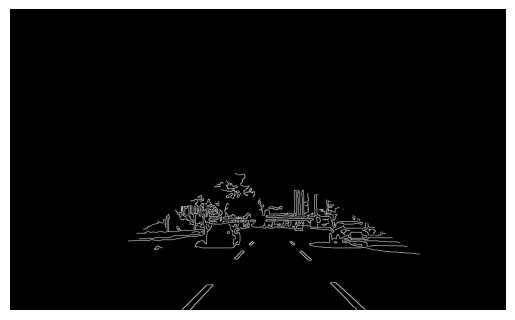

In [3]:
def roi_mask(img):
    """
    주어진 이미지에서 관심 영역(ROI)을 마스킹하는 함수입니다.

    이 함수는 다음 단계를 수행합니다:
    1. 이미지의 높이와 너비를 가져옵니다.
    2. 관심 영역을 정의하는 다각형을 설정합니다.
    3. 다각형을 사용하여 마스크를 생성합니다.
    4. 원본 이미지와 마스크를 비트 연산하여 관심 영역만 남깁니다.

    Args:
        img (numpy.ndarray): 마스킹할 입력 이미지.

    Returns:
        numpy.ndarray: 관심 영역이 마스킹된 이미지.
    """
    height = img.shape[0]
    width = img.shape[1]
    polygons = np.array([[(0, height), (round(width/2), round(height /2)), (1000, height)]])
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, polygons, 255)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

masked_img = roi_mask(canny_img)
plt.imshow(masked_img, cmap='gray')
plt.axis('off')
plt.show()

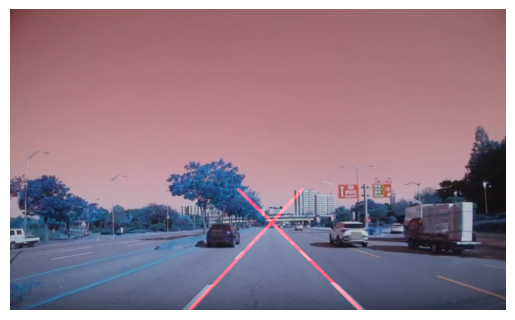

In [4]:
lines = cv2.HoughLinesP(masked_img, 
                        2, 
                        np.pi/180, 
                        100, 
                        np.array([]), 
                        minLineLength=40, 
                        maxLineGap=5)

def get_coordinates(img, params):
    """
    이미지와 선의 매개변수를 받아 선의 좌표를 계산하는 함수입니다.

    Args:
        img (numpy.ndarray): 입력 이미지.
        params (tuple): 선의 기울기와 절편을 포함하는 튜플.

    Returns:
        numpy.ndarray: 선의 시작점과 끝점 좌표를 포함하는 배열.
    """
    slope, intercept = params
    y1 = img.shape[0]
    y2 = int(y1 * (3/5))
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

def avg_lines(img, lines):
    """
    여러 선을 받아 평균 선을 계산하는 함수입니다.

    Args:
        img (numpy.ndarray): 입력 이미지.
        lines (numpy.ndarray): 여러 선의 배열.

    Returns:
        numpy.ndarray: 평균 선의 좌표를 포함하는 배열.
    """
    left = []
    right = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if 0.5 < abs(slope) < 2:
            if slope < 0:
                left.append((slope, intercept))
            else:
                right.append((slope, intercept))
    left_avg = np.average(left, axis=0)
    right_avg = np.average(right, axis=0)
    left_line = get_coordinates(img, left_avg)
    right_line = get_coordinates(img, right_avg)
    return np.array([left_line, right_line])

def draw_lines(image, lines, thickness):
    """
    이미지에 선을 그리는 함수입니다.

    Args:
        image (numpy.ndarray): 입력 이미지.
        lines (numpy.ndarray): 그릴 선의 좌표 배열.
        thickness (int): 선의 두께.

    Returns:
        numpy.ndarray: 선이 그려진 이미지.
    """
    line_image = np.zeros_like(image)
    color = (0, 0, 255)
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), thickness)
    combined_image = cv2.addWeighted(image, 0.8, line_image, 1.0, 0.0)
    return combined_image

combined_image = draw_lines(image, avg_lines(image, lines), 5)
plt.imshow(combined_image)
plt.axis('off')
plt.show()